### Importing basic packages

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('crest')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (20, 6)
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linewidth'] = 0.5
from warnings import filterwarnings
filterwarnings('ignore')

### Reading the Dataset

In [2]:
df = pd.read_csv("IMDB_Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


### Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


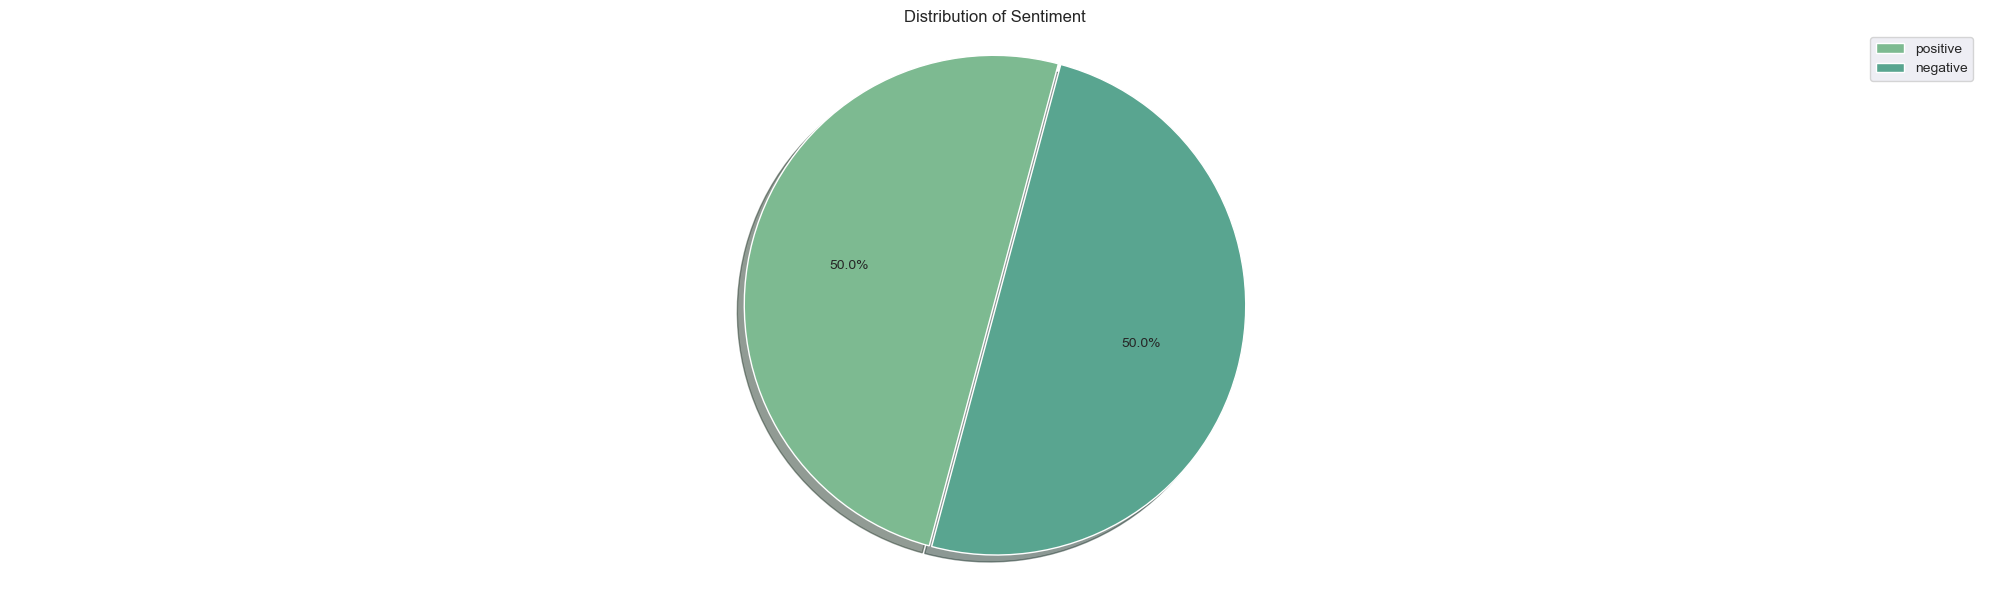

In [6]:
plt.pie(df['sentiment'].value_counts(), startangle=75,  explode=(0.0, 0.01), autopct='%1.1f%%', shadow=True)
plt.axis('equal')
plt.title("Distribution of Sentiment")
plt.legend(df['sentiment'].value_counts().index, loc='best')
plt.tight_layout()
plt.show()

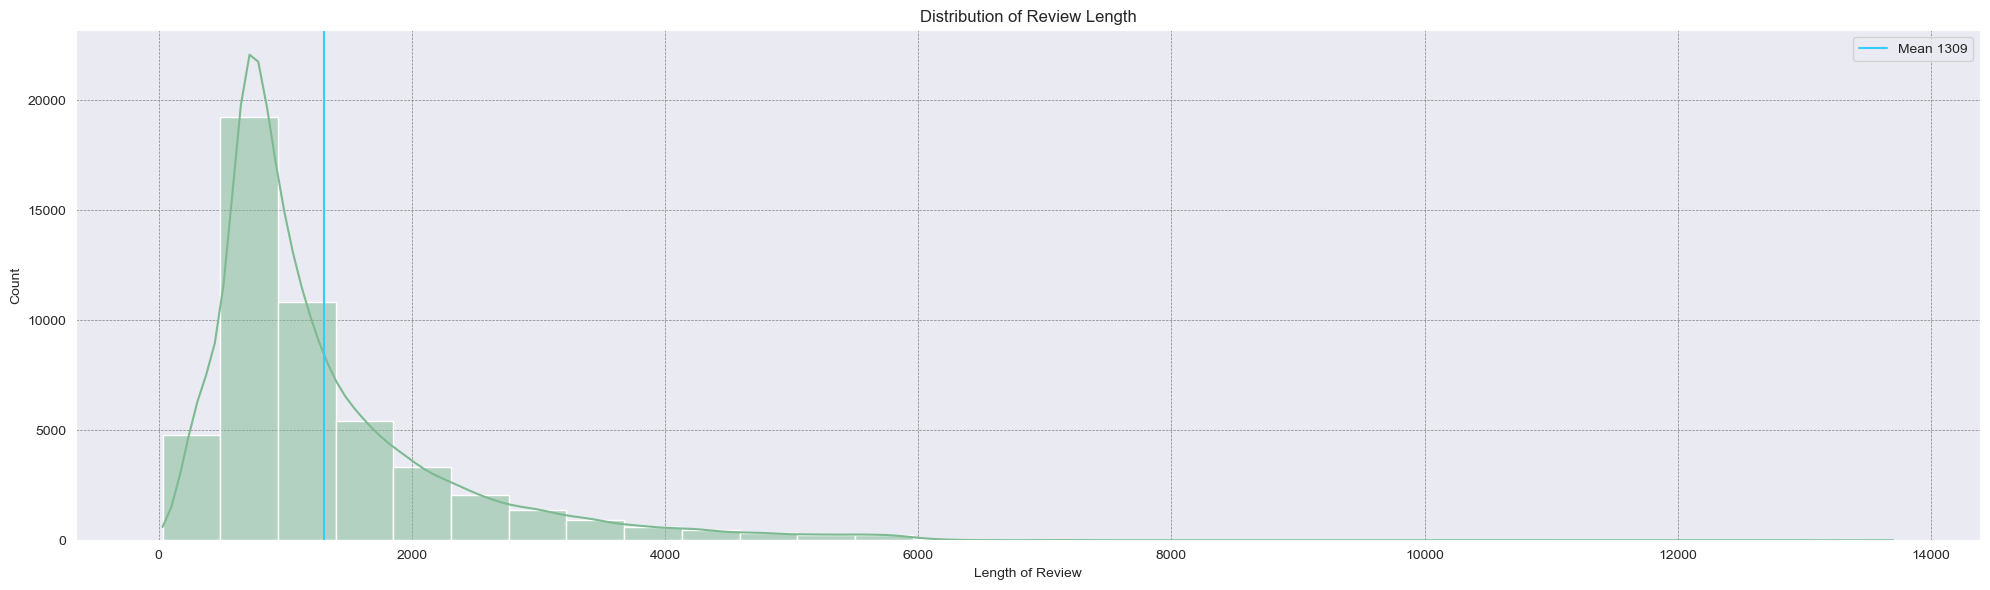

In [7]:
sns.histplot(df['review'].str.len(), bins=30, kde=True)
plt.title("Distribution of Review Length")
plt.xlabel("Length of Review")
plt.ylabel("Count")
mean = df['review'].str.len().mean()
plt.axvline(mean, linestyle='-', color='#33ccff', label=f'Mean {mean:.0f}')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [8]:
df.duplicated().sum()

418

In [9]:
df = df.drop_duplicates()

In [10]:
df['sentiment'].value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

In [11]:
df.shape[0]

49582

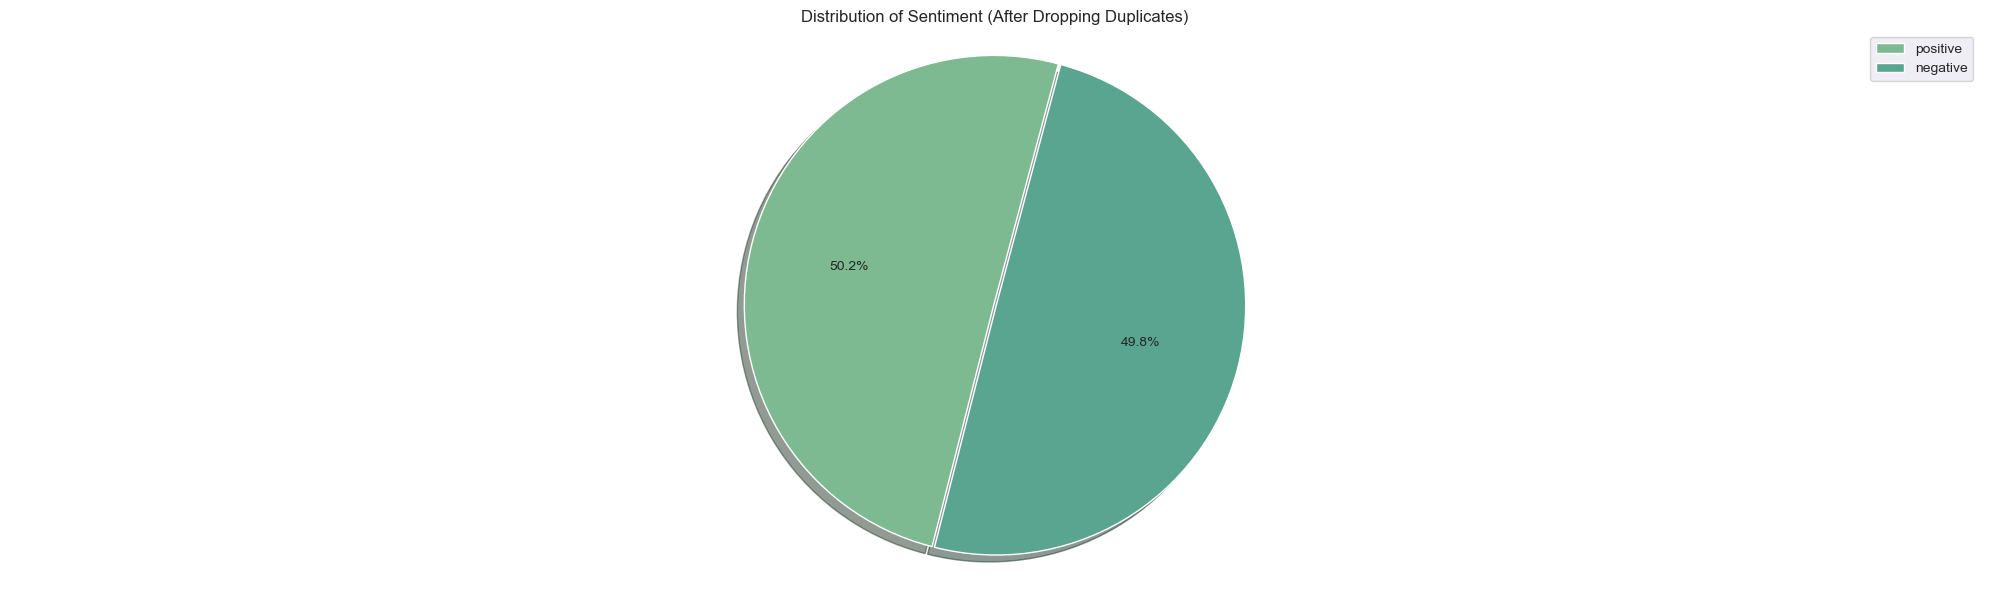

In [12]:
plt.pie(df['sentiment'].value_counts(), startangle=75,  explode=(0.0, 0.01), autopct='%1.1f%%', shadow=True)
plt.axis('equal')
plt.title("Distribution of Sentiment (After Dropping Duplicates)")
plt.legend(df['sentiment'].value_counts().index, loc='best')
plt.tight_layout()
plt.show()

#### Report: Exploratory Data Analysis

This dataset contains 50,000 reviews of movies from IMDB. The reviews are labeled as positive or negative. The dataset is balanced, with 25,000 positive and 25,000 negative reviews. There are 418 duplicated entires, after removing the duplicated values, 24884 positive and 24,698 negative remains. The average review length of a review contains around 1300 words.

### Preprocessing the data

In [13]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
import string

In [14]:
def normalize_text(text):
    text = text.lower()
    text = re.sub('<.*?>','', text)
    text = re.sub(r'https?://\S+|www\.\S+','', text)
    text = re.sub('\\W',' ', text)
    text = re.sub('\n', '', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('^ ', '', text)
    text = re.sub(' $', '', text)
    return text

In [15]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    words = text.split()
    sentence = ''
    for word in words:
        if word not in stop_words:
            sentence = sentence + word + ' '
    return sentence

In [16]:
def remove_punctuation(text):
    table = str.maketrans('','',string.punctuation)
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = word.translate(table)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence

In [17]:
def stemmer(text):
    ps = PorterStemmer()
    words = text.split()
    filtered_sentence = ''
    for word in words:
        word = ps.stem(word)
        filtered_sentence = filtered_sentence + word + ' '
    return filtered_sentence
    

In [18]:
def clean_text(text):
    text = text.lower()
    
    text = normalize_text(text)
    text = text.replace(',',' , ')
    text = text.replace('.',' . ')
    text = text.replace('/',' / ')
    text = text.replace('@',' @ ')
    text = text.replace('#',' # ')
    text = text.replace('?',' ? ')
    text = text.replace("'", " ' ")
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = stemmer(text)
    return text

In [19]:
df['review'] = df['review'].apply(clean_text)

In [20]:
df.head()

,review,sentiment
0,one review mention watch 1 oz episod hook righ...,positive
1,wonder littl product film techniqu unassum old...,positive
2,thought wonder way spend time hot summer weeke...,positive
3,basic famili littl boy jake think zombi closet...,negative
4,petter mattei love time money visual stun film...,positive


In [21]:
X = df['review'].values
y = df['sentiment'].values

### Preparing data for training and testing purpose

In [22]:
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=7)

### Parameter Tuning and Model fitting

#### Logistic Regression with TF-IDF

##### Parameter Tuning using GridSearchCV

In [24]:
tf = TfidfVectorizer()
lr = LogisticRegression()
log_reg_model = Pipeline([('vectorizer', tf), ('classifier', lr)])
param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [ 0.01, 0.1, 1.0],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [50, 100]
}
grid_search = GridSearchCV(estimator=log_reg_model,
                           param_grid=param_grid, cv=5, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END classifier__C=0.01, classifier__max_iter=50, classifier__penalty=l1, classifier__solver=liblinear; total time=   5.0s
[CV] END classifier__C=0.01, classifier__max_iter=50, classifier__penalty=l1, classifier__solver=liblinear; total time=   5.4s
[CV] END classifier__C=0.01, classifier__max_iter=50, classifier__penalty=l1, classifier__solver=liblinear; total time=   4.4s
[CV] END classifier__C=0.01, classifier__max_iter=50, classifier__penalty=l1, classifier__solver=liblinear; total time=   4.3s
[CV] END classifier__C=0.01, classifier__max_iter=50, classifier__penalty=l1, classifier__solver=liblinear; total time=   4.3s
[CV] END classifier__C=0.01, classifier__max_iter=50, classifier__penalty=l1, classifier__solver=saga; total time=   5.1s
[CV] END classifier__C=0.01, classifier__max_iter=50, classifier__penalty=l1, classifier__solver=saga; total time=   6.5s
[CV] END classifier__C=0.01, classifier__max_iter=50, class

##### Model Training

In [24]:
tf = TfidfVectorizer()
lr = LogisticRegression(penalty='l2', C=1.0, solver='liblinear', max_iter=50)
lr_model_tf = Pipeline([('vectorizer', tf), ('classifier', lr)])
lr_model_tf.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 LogisticRegression(max_iter=50, solver='liblinear'))])

In [25]:
y_pred_lr_tf = lr_model_tf.predict(X_test)

##### Results

###### Accuracy

In [26]:
lr_tf_accuracy = accuracy_score(y_test, y_pred_lr_tf)
print(lr_tf_accuracy)

0.892104467076737


###### Classification Report

In [27]:
print(classification_report(y_test, y_pred_lr_tf))
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)
y_pred_lr_tf_encoded = label_encoder.transform(y_pred_lr_tf)

              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      4996
    positive       0.88      0.90      0.89      4921

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



###### Confusion Matrix

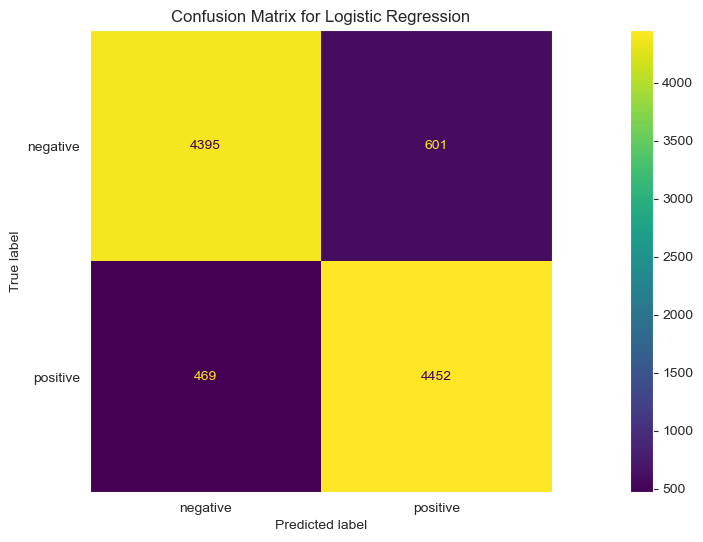

In [28]:
cm = confusion_matrix(y_test, y_pred_lr_tf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model_tf.classes_)
disp.plot()
plt.title("Confusion Matrix for Logistic Regression")
plt.grid(False)
plt.show()

###### ROC-AUC Curve

In [29]:
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_lr_tf_encoded)

In [30]:
auc = roc_auc_score(y_test_encoded, y_pred_lr_tf_encoded)
print(f"AUC: {auc:.2f}")

AUC: 0.89


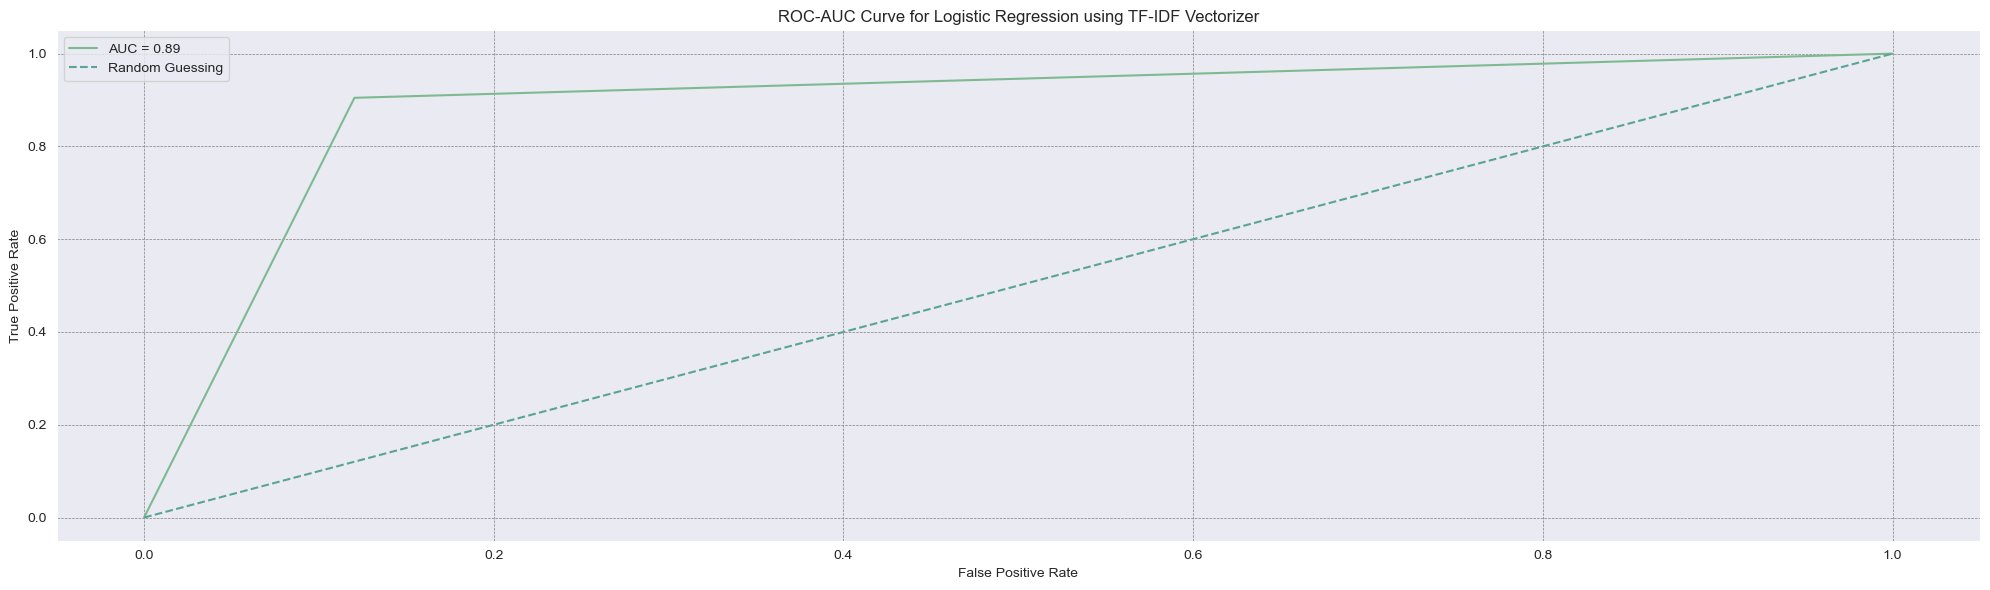

In [ ]:
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Logistic Regression using TF-IDF Vectorizer')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Decision Tree with TF-IDF

##### Parameter Tuning

In [33]:
dt = DecisionTreeClassifier()
dt_model = Pipeline([('vectorizer', tf), ('classifier', dt)])
param_grid = {
    'classifier__criterion':['gini','entropy'],
    'classifier__splitter':['best', 'random'],
    'classifier__ccp_alpha':[0.01,0.001]
}
grid_search = GridSearchCV(estimator= dt_model, param_grid=param_grid,
                           cv = 5, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END classifier__ccp_alpha=0.01, classifier__criterion=gini, classifier__splitter=best; total time= 1.1min
[CV] END classifier__ccp_alpha=0.01, classifier__criterion=gini, classifier__splitter=best; total time= 1.0min
[CV] END classifier__ccp_alpha=0.01, classifier__criterion=gini, classifier__splitter=best; total time= 1.0min
[CV] END classifier__ccp_alpha=0.01, classifier__criterion=gini, classifier__splitter=best; total time= 1.1min
[CV] END classifier__ccp_alpha=0.01, classifier__criterion=gini, classifier__splitter=best; total time= 1.1min
[CV] END classifier__ccp_alpha=0.01, classifier__criterion=gini, classifier__splitter=random; total time=  51.7s
[CV] END classifier__ccp_alpha=0.01, classifier__criterion=gini, classifier__splitter=random; total time=  55.4s
[CV] END classifier__ccp_alpha=0.01, classifier__criterion=gini, classifier__splitter=random; total time=  56.0s
[CV] END classifier__ccp_alpha=0.01, classifie

##### Model Training

In [34]:
dt = DecisionTreeClassifier(criterion='entropy', ccp_alpha=0.001, splitter='best')
dt_model = Pipeline([('vectorizer', tf), ('classifier', dt)])
dt_model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy'))])

In [35]:
y_pred_dt = dt_model.predict(X_test)

##### Results

###### Accuracy Score

In [36]:
dt_accuracy = accuracy_score(y_test, y_pred_dt)
print(dt_accuracy)

0.7544620348895835


###### Classification_Report 

In [37]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

    negative       0.77      0.73      0.75      4996
    positive       0.74      0.78      0.76      4921

    accuracy                           0.75      9917
   macro avg       0.76      0.75      0.75      9917
weighted avg       0.76      0.75      0.75      9917



###### Confusion Matrix

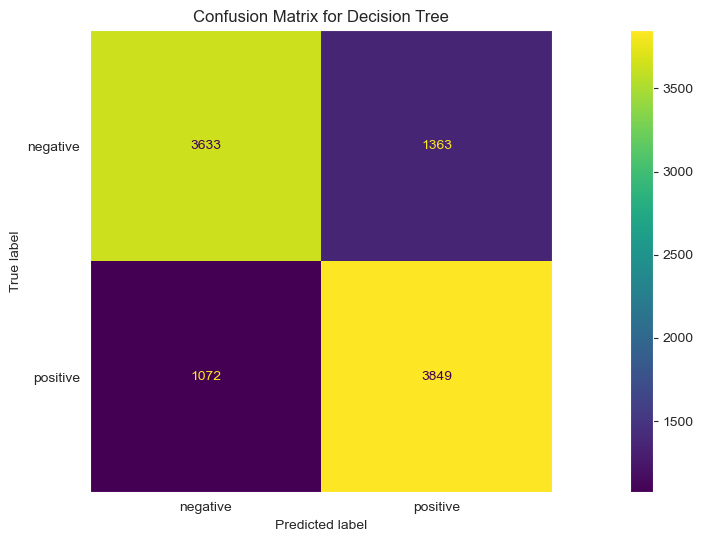

In [38]:
cm = confusion_matrix(y_test, y_pred_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot()
plt.title("Confusion Matrix for Decision Tree")
plt.grid(False)
plt.show()

##### Roc-Auc Curve

In [39]:
y_pred_dt_encoded = label_encoder.transform(y_pred_dt)
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_dt_encoded)
auc = roc_auc_score(y_test_encoded, y_pred_dt_encoded)
print(f"AUC: {auc:.2f}")

AUC: 0.75


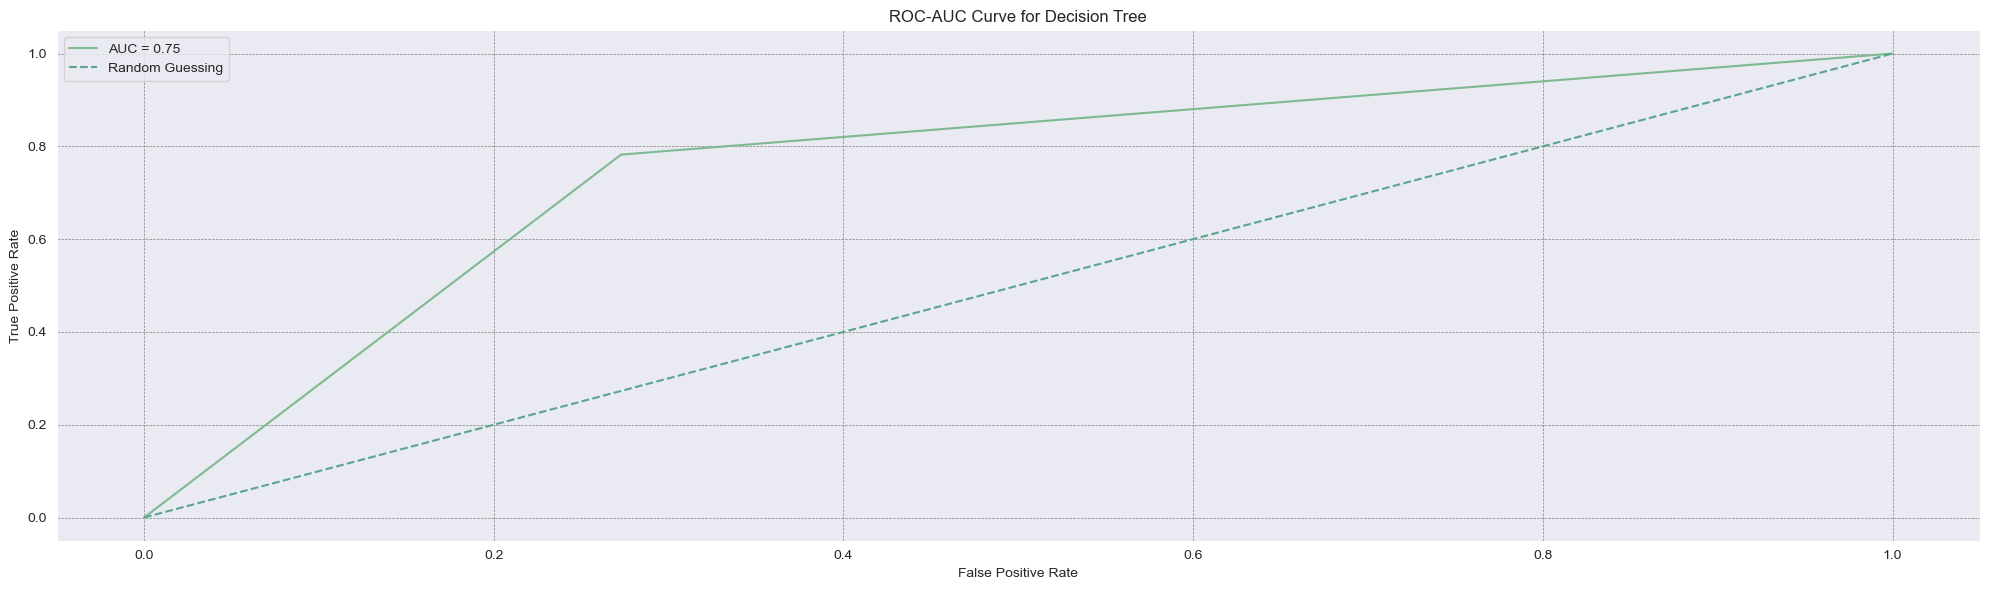

In [40]:
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Decision Tree')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Random Forest model with TF-IDF 

In [41]:
rf = RandomForestClassifier(n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', max_depth=None, bootstrap=False)
rf_model = Pipeline([('vectorizer', tf), ('classifier', rf)])
rf_model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, min_samples_leaf=2,
                                        n_estimators=200))])

In [42]:
y_pred_rf = rf_model.predict(X_test)

In [43]:
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_accuracy

0.8594332963597863

In [44]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

    negative       0.87      0.85      0.86      4996
    positive       0.85      0.87      0.86      4921

    accuracy                           0.86      9917
   macro avg       0.86      0.86      0.86      9917
weighted avg       0.86      0.86      0.86      9917



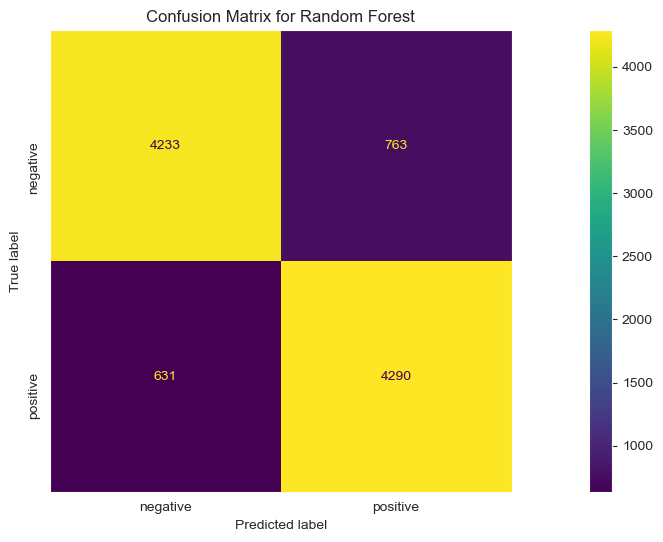

In [45]:
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()
plt.title("Confusion Matrix for Random Forest")
plt.yticks(rotation=90)
plt.grid(False)
plt.show()

In [46]:
y_pred_rf_encoded = label_encoder.transform(y_pred_rf)
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_rf_encoded)
auc = roc_auc_score(y_test_encoded, y_pred_rf_encoded)
print(f"AUC: {auc:.2f}")

AUC: 0.86


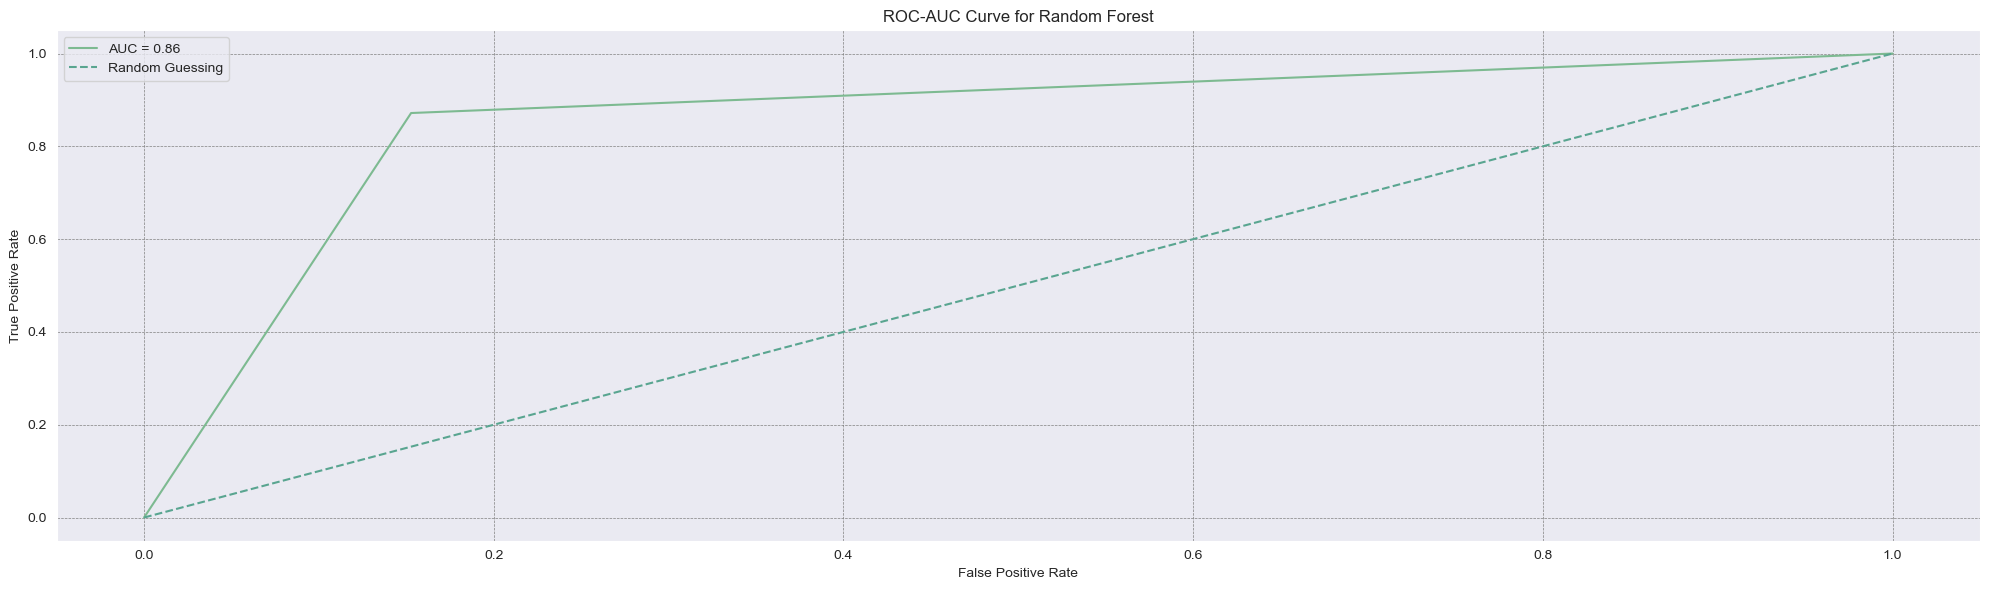

In [47]:
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Random Forest')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Support Vector Classifier with TF-IDF 

##### ParameterTuning

In [ ]:
from sklearn.svm import SVC
svm = Pipeline([('vectorizer', tf), ('classifier', SVC())])
param_grid = {
    'classifier__kernel':['linear','rbf'],
    'classifier__C':[0.01,0.1,1.0],
    'classifier__gamma':['scale','auto']
}
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__C=0.01, classifier__gamma=scale, classifier__kernel=linear; total time=  17.6s
[CV] END classifier__C=0.01, classifier__gamma=scale, classifier__kernel=linear; total time=  19.1s
[CV] END classifier__C=0.01, classifier__gamma=scale, classifier__kernel=linear; total time=  19.6s
[CV] END classifier__C=0.01, classifier__gamma=scale, classifier__kernel=linear; total time=  19.6s
[CV] END classifier__C=0.01, classifier__gamma=scale, classifier__kernel=linear; total time=  19.7s
[CV] END classifier__C=0.01, classifier__gamma=scale, classifier__kernel=rbf; total time=  24.7s
[CV] END classifier__C=0.01, classifier__gamma=scale, classifier__kernel=rbf; total time=  23.2s
[CV] END classifier__C=0.01, classifier__gamma=scale, classifier__kernel=rbf; total time=  23.2s
[CV] END classifier__C=0.01, classifier__gamma=scale, classifier__kernel=rbf; total time=  23.2s
[CV] END classifier__C=0.01, classifier__gamma=scal

##### Model Training

In [49]:
from sklearn.svm import SVC
svm_model = Pipeline([('vectorizer', tf), ('classifier', SVC(C = 1.0, gamma = 'scale', kernel = 'rbf'))])
svm_model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('classifier', SVC())])

In [50]:
y_pred_svm = svm_model.predict(X_test)

##### Result

###### Accuracy 

In [51]:
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(svm_accuracy)

0.8972471513562569


###### Classification Report

In [52]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

    negative       0.91      0.89      0.90      4996
    positive       0.89      0.91      0.90      4921

    accuracy                           0.90      9917
   macro avg       0.90      0.90      0.90      9917
weighted avg       0.90      0.90      0.90      9917



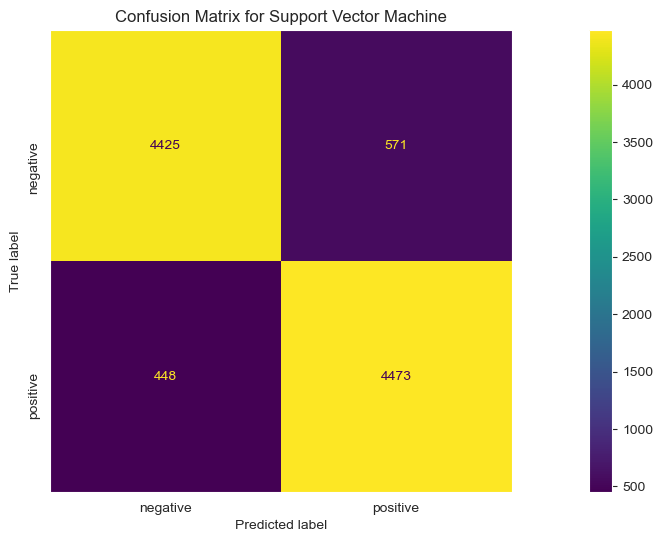

In [53]:
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot()
plt.title("Confusion Matrix for Support Vector Machine")
plt.yticks(rotation=90)
plt.grid(False)
plt.show()

In [54]:
y_pred_svm_encoded = label_encoder.transform(y_pred_svm)
fpr, tpr, thresholds = roc_curve(y_test_encoded, y_pred_svm_encoded)
auc = roc_auc_score(y_test_encoded, y_pred_svm_encoded)
print(f"AUC: {auc:.2f}")

AUC: 0.90


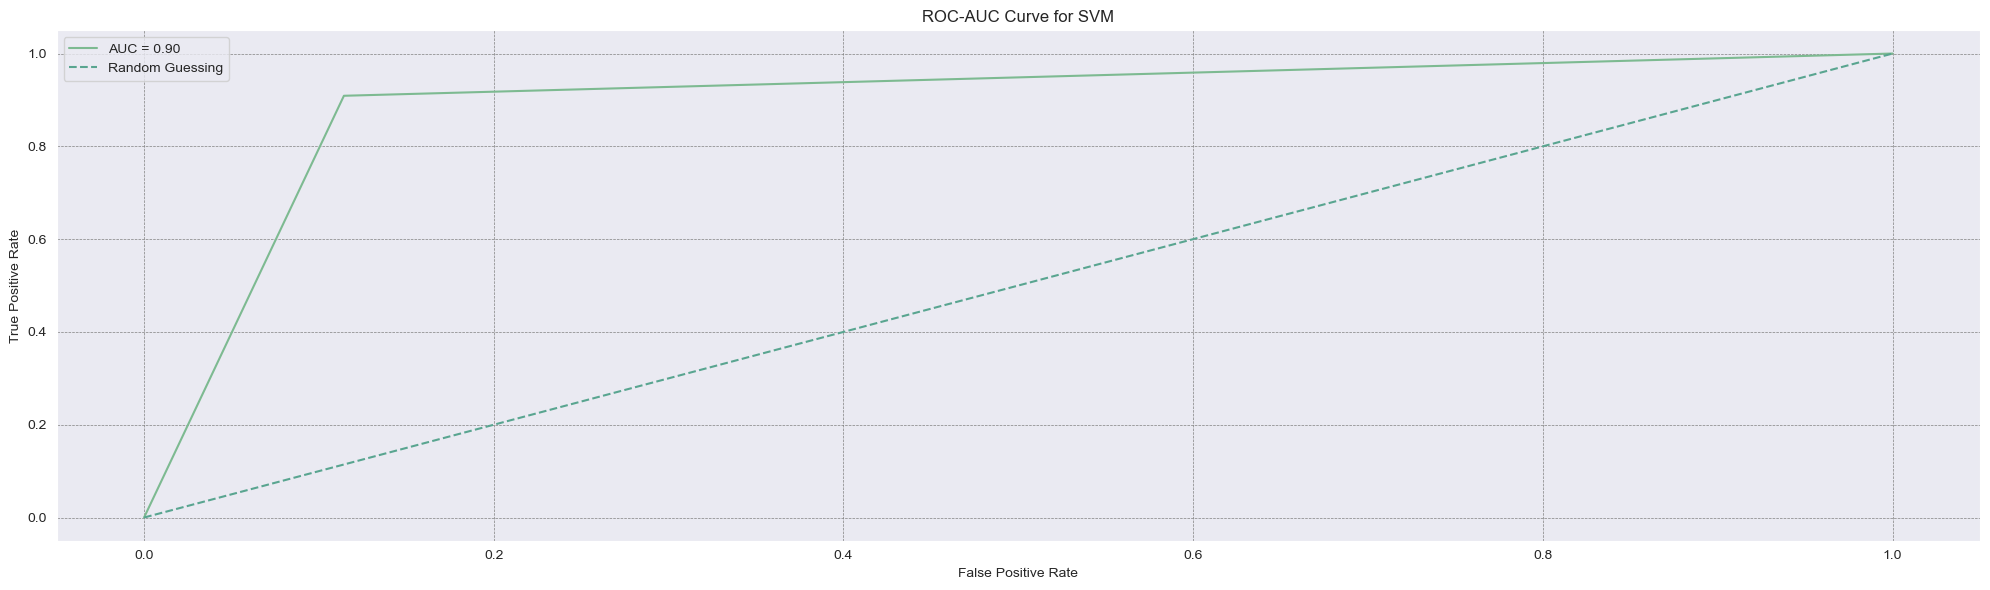

In [55]:
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for SVM')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

#### NaiveBiasClassifier with TF-IDF

In [80]:
from sklearn.naive_bayes import MultinomialNB
nb = Pipeline([('vectorizer', tf), ('classifier', MultinomialNB())])
param_grid = {
    'classifier__alpha':[0.01,0.1,1.0],
    'classifier__fit_prior':[True,False]
}
grid_search = GridSearchCV(estimator=nb, param_grid=param_grid, cv=5, verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .classifier__alpha=0.01, classifier__fit_prior=True; total time=   3.5s
[CV] END .classifier__alpha=0.01, classifier__fit_prior=True; total time=   3.4s
[CV] END .classifier__alpha=0.01, classifier__fit_prior=True; total time=   3.6s
[CV] END .classifier__alpha=0.01, classifier__fit_prior=True; total time=   3.8s
[CV] END .classifier__alpha=0.01, classifier__fit_prior=True; total time=   4.6s
[CV] END classifier__alpha=0.01, classifier__fit_prior=False; total time=   7.9s
[CV] END classifier__alpha=0.01, classifier__fit_prior=False; total time=   7.7s
[CV] END classifier__alpha=0.01, classifier__fit_prior=False; total time=   7.2s
[CV] END classifier__alpha=0.01, classifier__fit_prior=False; total time=   7.4s
[CV] END classifier__alpha=0.01, classifier__fit_prior=False; total time=   6.8s
[CV] END ..classifier__alpha=0.1, classifier__fit_prior=True; total time=   7.3s
[CV] END ..classifier__alpha=0.1, classifier__fit

In [56]:
from sklearn.naive_bayes import MultinomialNB
nb_model = Pipeline([('vectorizer', tf), ('classifier', MultinomialNB(alpha=1.0, fit_prior=True))])
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print(nb_accuracy)

0.8596349702531008


### Overall Result

In [ ]:
models = ['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier', 'SupportVectorClassifier', 'NaiveBayesClassifier']
accuracy = [lr_tf_accuracy, dt_accuracy, rf_accuracy, svm_accuracy, nb_accuracy]
results = pd.DataFrame({'Models':models, 'Accuracy':accuracy})


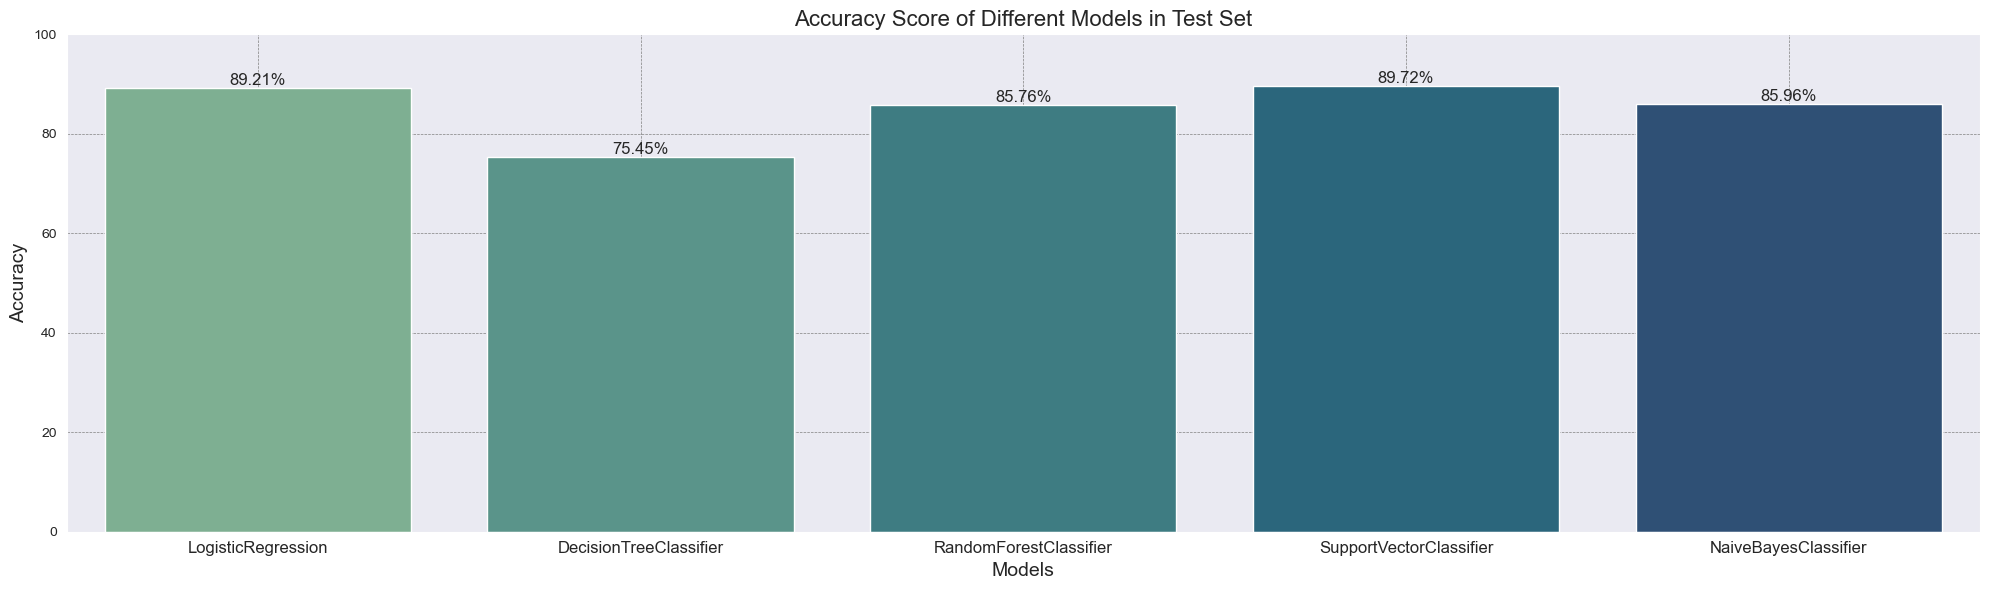

In [103]:
ax = sns.barplot(x=results.Models, y=results.Accuracy * 100, legend=True, palette='crest')
plt.grid(True)
plt.title("Accuracy Score of Different Models in Test Set", fontsize=16)
plt.xlabel("Models", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.xticks(fontsize=12)
plt.ylim(0, 100)
for bar in ax.patches:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}%', (bar.get_x() + bar.get_width() / 2, height), 
                ha='center', va='bottom', fontsize = 12)
plt.tight_layout()
plt.show()

In [104]:
def test(review):
    a = review
    print("The Review:", a)
    text = normalize_text(review)
    pred = svm_model.predict([text])
    print("Result:", pred[0]) 

In [105]:
review = 'This movie is absolutely terrible. The directing, acting, script and production are all bad. There is actually NOTHING redeemable about it.'
test(review)

The Review: This movie is absolutely terrible. The directing, acting, script and production are all bad. There is actually NOTHING redeemable about it.
Result: negative


In [106]:
review = 'Excellent spy thriller ... Loved this movie. Joshua Caldwell actually takes the time for the audience to get to know and understand the characters so you care ...'
test(review)

The Review: Excellent spy thriller ... Loved this movie. Joshua Caldwell actually takes the time for the audience to get to know and understand the characters so you care ...
Result: positive


In [ ]:
review = "People seem of two minds about this film: it either moves them to tears or to nausea. But in reality, it is a well-made film with some strong performances but not more than that. The core of this movie that is as simple minded as the title character; the facile speciousness of the movie's reactionary attacks on matters I agreed with made me realize just how shallow the movie's entire argument is.  But beyond that, the movie is very well made; Hanks's performance could have been annoying in other hands but works well here. Sinise was excellent as well. Robin Wright's performance was adequate - I try not to blame her for the movie's implied argument that the social movements of the 60's and 70's were a working out of childhood neuroses - but never really stuck to me. The technical aspects of the film are outstanding, and the movie has a lot of laughs and tears despite its empty headed core.  If it helps anyone, this is my wife's favorite movie. But then, she fell asleep during Casablanca, so...."
test(review)

The Review: People seem of two minds about this film: it either moves them to tears or to nausea. But in reality, it is a well-made film with some strong performances but not more than that. The core of this movie that is as simple minded as the title character; the facile speciousness of the movie's reactionary attacks on matters I agreed with made me realize just how shallow the movie's entire argument is.  But beyond that, the movie is very well made; Hanks's performance could have been annoying in other hands but works well here. Sinise was excellent as well. Robin Wright's performance was adequate - I try not to blame her for the movie's implied argument that the social movements of the 60's and 70's were a working out of childhood neuroses - but never really stuck to me. The technical aspects of the film are outstanding, and the movie has a lot of laughs and tears despite its empty headed core.  If it helps anyone, this is my wife's favorite movie. But then, she fell asleep durin